In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imread, imshow
import shutil
import keras
from keras import layers
import os
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input, LeakyReLU ,Dropout
from keras.models import Sequential

### First Download the Kaggle.json API to work with the database without the need to download it

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download theblackmamba31/landscape-image-colorization

landscape-image-colorization.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip landscape-image-colorization.zip

In [ ]:
shutil.rmtree("/content/landscape Images/gray")

In [ ]:
TRAIN_DIR = "/content/landscape Images"
destination = "/content/train/images"

#checking if the training file exists
if not os.path.exists(destination):
    os.makedirs(destination)

### Making A directory for Colored Images only

In [ ]:
#/content/landscape Images/color/0.jpg
for DIR in os.listdir(TRAIN_DIR):
        for img in os.listdir(os.path.join(TRAIN_DIR, DIR)):
            source = os.path.join(TRAIN_DIR, DIR, img)
            try:
                imread(source)
                shutil.copy(source, destination)
            except:
                print(f"The image at {source} cannot be read")

### Training data generator

In [ ]:
train_data_gen = ImageDataGenerator(rescale= 1/255 ,
                                    featurewise_center= True,
                                    horizontal_flip= True,
                                    featurewise_std_normalization= True)

train = train_data_gen.flow_from_directory("/content/train",
                                           target_size=(256,256),
                                           batch_size= 500,
                                           shuffle= True)

Found 7129 images belonging to 1 classes.


In [ ]:
t_img, lable = train.next()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


### Now we plot our Training data as images

In [ ]:
def plotimage(img_arr, lable):
    """
    input: images in the training dataset
    output: plotting a selected number of them
    """
    
    plt.figure(figsize=(5,5))
    
    for im , l in zip(img_arr ,lable):
        plt.imshow(im)
        plt.title(im.shape)
        plt.axis('off')
        plt.show()

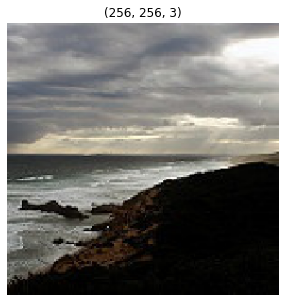

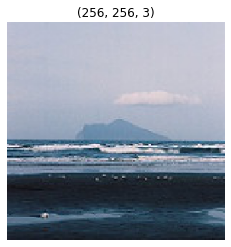

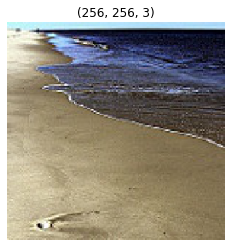

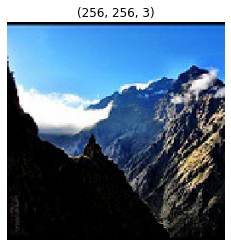

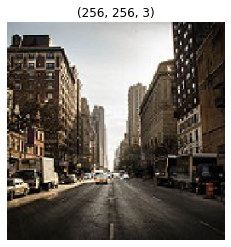

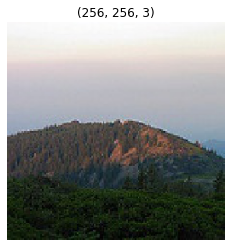

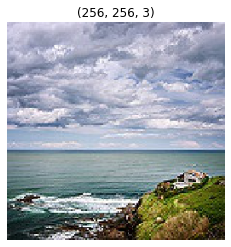

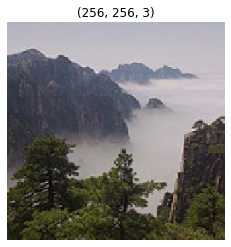

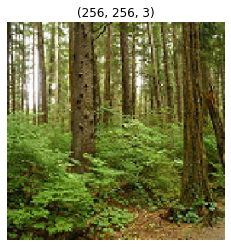

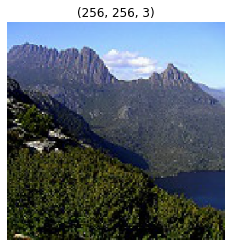

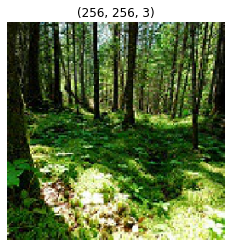

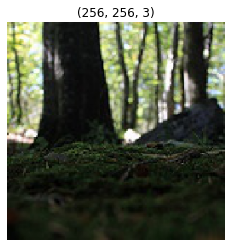

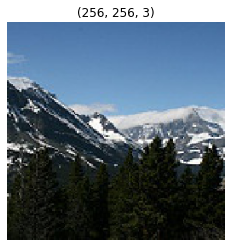

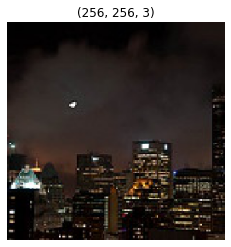

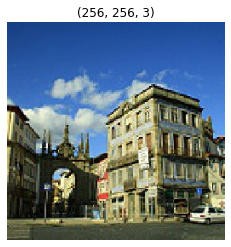

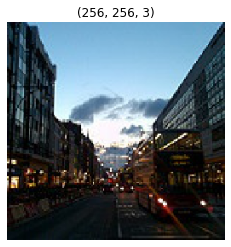

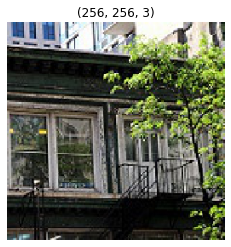

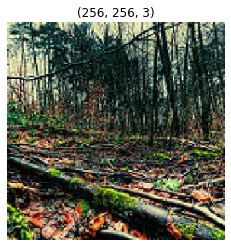

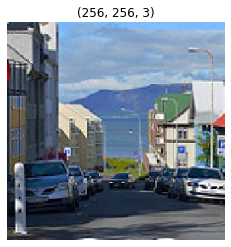

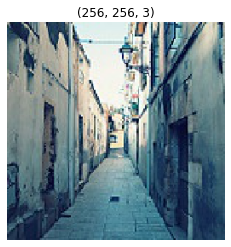

In [ ]:
plotimage(t_img[:20], lable[:20])

## making two vectors where images are grayscale in one and colored in the other

In [ ]:
#training and desired response images
x= []
y= []

#converting images to grayscale using the lab format (black&white, red&green, blue&yellow)
for img in t_img:
    try:
        lab = rgb2lab(img)
        x.append(lab[:,:,0])
        y.append(lab[:,:,1:]/128)
    except:
        print('error')

### converting these image vectors into numpy arrays

In [ ]:
x_train = np.array(x)
x_train = np.expand_dims(x_train, axis = len(x_train.shape))

y_train = np.array(y)

## Building the model (Autoencoder)

In [ ]:
model = Sequential()
#Encoder
model.add(Conv2D(64, (3,3), activation='relu', padding='same', strides=2, input_shape = (256,256,1)))
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(Conv2D(128,(3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(Conv2D(256,(3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))

#decoder
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2,(3,3), activation= LeakyReLU(alpha=0.001), padding='same'))
model.add(UpSampling2D((2,2)))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 512)      

### Compiling the Model

In [ ]:
model.compile(optimizer = "adam", loss = 'mean_absolute_error',metrics = ['acc'] )

In [ ]:
his = model.fit(x_train, y_train, epochs= 50, batch_size= 64, steps_per_epoch= x_train.shape[0]//64, verbose= 1)

Epoch 1/50
7/7 [==============================] - 10s 1s/step - loss: 0.1251 - acc: 0.5228
Epoch 2/50
7/7 [==============================] - 8s 1s/step - loss: 0.0756 - acc: 0.5044
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 0.0778 - acc: 0.5304
Epoch 4/50
7/7 [==============================] - 8s 1s/step - loss: 0.0754 - acc: 0.4951
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 0.0779 - acc: 0.5518
Epoch 6/50
7/7 [==============================] - 8s 1s/step - loss: 0.0747 - acc: 0.5314
Epoch 7/50
7/7 [==============================] - 8s 1s/step - loss: 0.0766 - acc: 0.4993
Epoch 8/50
7/7 [==============================] - 8s 1s/step - loss: 0.0780 - acc: 0.5043
Epoch 9/50
7/7 [==============================] - 9s 1s/step - loss: 0.0759 - acc: 0.5106
Epoch 10/50
7/7 [==============================] - 8s 1s/step - loss: 0.0788 - acc: 0.4955
Epoch 11/50
7/7 [==============================] - 8s 1s/step - loss: 0.0753 - acc: 0.4936
Epoch 1

### Saving the first model for the first training session 
#### (estimately took 1hr 40mins on jupyter_notebook )

In [ ]:
# evaluate the model
scores = model.evaluate(x_train, y_train, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
 
# serialize model to JSON
model_json = model.to_json()
with open("model2_ANNProject.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2_ANNProject.h5")
print("Saved model2_ANNProject to disk")

16/16 [==============================] - 4s 209ms/step - loss: 0.0764 - acc: 0.5163
acc: 51.63%
Saved model2_ANNProject to disk


In [ ]:
model.save('model2_ANNProject.h5')

### Testing to decide whether to train more or not:


#### Generic old grayscale photo from Google images:

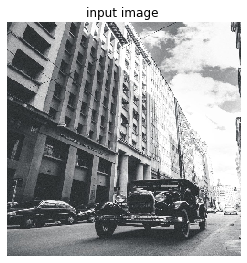

In [ ]:
image1_color = []
path = "/content/cars-on-the-road-wallpaper-preview.jpg"
img = img_to_array(
    load_img(path, target_size=(256,256,3))
)/255

plt.title("input image ")
imshow(img)
plt.axis("off")
plt.show()

#### Converting to lab format:

In [ ]:
image1_color.append(img)
image1_color = rgb2lab(image1_color)[:,:,:,0] #the zero is to make sure only grayscale components appear

image1_color = image1_color.reshape(image1_color.shape+(1,))

#### Predecting the color and reshaping into 256x265x3

In [ ]:
#predection
output1 = model.predict(image1_color)
output1 = output1*128
#[0 1 2 3 5 4 6 2555 6  2  2  5 1 2]

#array to expand the output with
result = np.zeros((256,256,3))
result[:,:,0] = image1_color[0][:,:,0]
result[:,:,1:] = output1[0]

#### plotting the predection

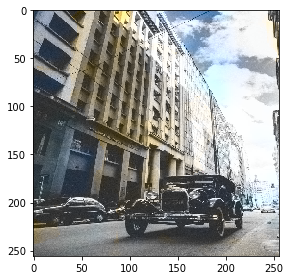

In [ ]:
imshow(lab2rgb(result))

### further training with similar examples

In [ ]:
#loading the trained model
from keras.models import load_model
model = load_model('model_450epoch_ANNProject.h5')

#training a bigger epoch
model.fit(x_train, y_train, epochs= 100, batch_size= 64, steps_per_epoch= x_train.shape[0]//64, verbose= 1)

Epoch 1/100
7/7 [==============================] - 9s 1s/step - loss: 0.0367 - acc: 0.8327
Epoch 2/100
7/7 [==============================] - 8s 1s/step - loss: 0.0376 - acc: 0.8390
Epoch 3/100
7/7 [==============================] - 8s 1s/step - loss: 0.0359 - acc: 0.8355
Epoch 4/100
7/7 [==============================] - 8s 1s/step - loss: 0.0381 - acc: 0.8281
Epoch 5/100
7/7 [==============================] - 8s 1s/step - loss: 0.0435 - acc: 0.8121
Epoch 6/100
7/7 [==============================] - 9s 1s/step - loss: 0.0432 - acc: 0.8189
Epoch 7/100
7/7 [==============================] - 9s 1s/step - loss: 0.0425 - acc: 0.8062
Epoch 8/100
7/7 [==============================] - 9s 1s/step - loss: 0.0429 - acc: 0.8157
Epoch 9/100
7/7 [==============================] - 9s 1s/step - loss: 0.0411 - acc: 0.8127
Epoch 10/100
7/7 [==============================] - 9s 1s/step - loss: 0.0411 - acc: 0.8203
Epoch 11/100
7/7 [==============================] - 9s 1s/step - loss: 0.0403 - acc: 0.81

In [ ]:
# evaluate the model
scores = model.evaluate(x_train, y_train, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
 
# serialize model to JSON
model_json = model.to_json()
with open("model_500epoch_ANNProject.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_500epoch_ANNProject.h5")
print("Saved model_450epoch_ANNProject to disk")

16/16 [==============================] - 4s 213ms/step - loss: 0.0380 - acc: 0.8233
acc: 82.33%
Saved model_450epoch_ANNProject to disk


In [ ]:
model.save('model_500epoch_ANNProject.h5')